In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
energydata = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata['date_time'] = pd.to_datetime(
    energydata['date_time'], format='%Y-%m-%d %H:%M:%S')
energydata = energydata.set_index("date_time")

In [3]:
energydata

,energy_consumption
date_time,
2016-12-26 00:00:00,41.81025
2016-12-26 01:00:00,39.73950
2016-12-26 02:00:00,38.78525
2016-12-26 03:00:00,38.96900
2016-12-26 04:00:00,39.18750
...,...
2023-11-22 08:00:00,65.75125
2023-11-22 09:00:00,67.40950
2023-11-22 10:00:00,68.26775


# Politische Unsicherheit 
* Mean: Modellieren durch DAX --> Mittelwert der letzten 7 Tage
* Frage: Eher Close-Werte, relative oder absolute Log-Returns? 

(Volatiliy am Ende addieren)

Ergebnis: 
Höchste Korrelation zwischen mean_Dax-Close-Werten und mean_energy_consumption (pro Woche), absolute und relative Werte geringere Korrelation (<0.05)

In [4]:
import yfinance as yf
from dax.help_functions.calculate_returns import calculate_return

def calculate_dax_means(energydata):

    # import daxdata accordingly to energydaata
    first_timestamp = energydata.index.min() - pd.DateOffset(days=8) # offset due to lag and mean calculations
    last_timestamp = energydata.index.max()

    msft = yf.Ticker("^GDAXI")
    daxdata = msft.history(start = first_timestamp, end = last_timestamp)

    # calculate returns and weekly means
    daxdata = calculate_return(daxdata)[['Close', 'LogRetLag1']]
    daxdata['AbsLogRetLag1'] = daxdata['LogRetLag1'].abs()
    daxdata['CloseMean5Days'] = daxdata['Close'].rolling(window=5).mean()
    daxdata['AbsLogRetLag1Mean5Days'] = daxdata['AbsLogRetLag1'].rolling(
        window=5).mean()
    
    # store weekly means for every week starting by wednesday
    current_closevalue = np.nan
    current_abslogretvalue = np.nan
    daxdata['Weekday'] = daxdata.index.weekday

    for index, row in daxdata.iterrows():
        if row['Weekday'] == 2:
            current_closevalue = row['CloseMean5Days']
            current_abslogretvalue = row['AbsLogRetLag1Mean5Days']

        daxdata.loc[index, 'close_weekly'] = current_closevalue
        daxdata.loc[index, 'abs_log_ret_weekly'] = current_abslogretvalue
    
    # drop NaNs and select columns
    daxdata = daxdata.dropna(subset=['close_weekly', 'abs_log_ret_weekly',
                                     'LogRetLag1', 'AbsLogRetLag1', 'CloseMean5Days', 
                                     'AbsLogRetLag1Mean5Days'])[['close_weekly', 'abs_log_ret_weekly']]
    
    return daxdata

def ec_dax_merge(energydata, daxdata=pd.DataFrame): 

    if daxdata.empty: 
        daxdata = calculate_dax_means(energydata)
    
    # prepare for merge
    energydata['date'] = energydata.index.date
    energydata = energydata.reset_index()
    daxdata['date'] = daxdata.index.date

    # merge data
    energy_merged = pd.merge(daxdata, energydata, how='left', on='date').set_index(
        'date_time').drop(columns={'date'})

    return (energy_merged)



In [7]:
ec_merge = calculate_dax_means(energydata)
ec_merge

ec_merged = ec_dax_merge(energydata, ec_merge)
ec_merged

,close_weekly,abs_log_ret_weekly,energy_consumption
date_time,,,
2016-12-28 00:00:00,11464.379883,0.083182,45.54875
2016-12-28 01:00:00,11464.379883,0.083182,43.06450
2016-12-28 02:00:00,11464.379883,0.083182,41.96000
2016-12-28 03:00:00,11464.379883,0.083182,41.95750
2016-12-28 04:00:00,11464.379883,0.083182,43.31375
...,...,...,...
2023-11-22 08:00:00,15893.090234,0.311336,65.75125
2023-11-22 09:00:00,15893.090234,0.311336,67.40950
2023-11-22 10:00:00,15893.090234,0.311336,68.26775


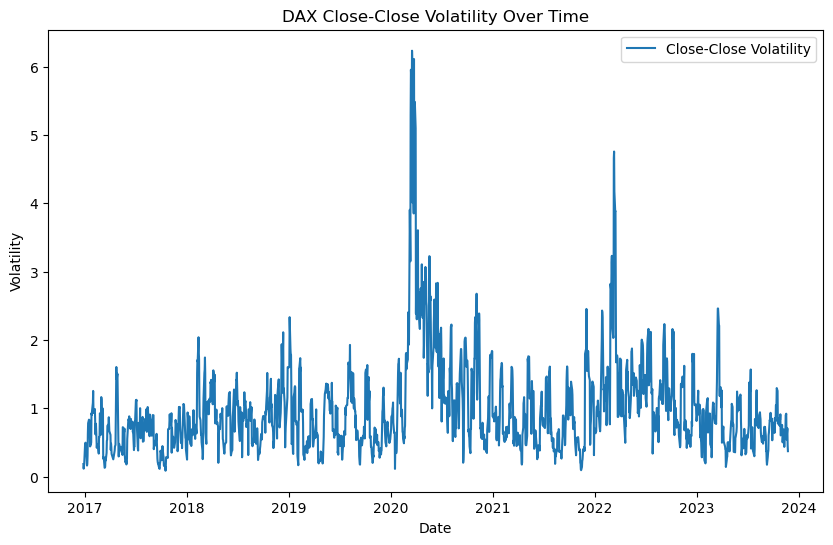

In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
from dax.help_functions.calculate_returns import calculate_return

# import daxdata accordingly to energydaata
# offset due to lag and mean calculations
first_timestamp = energydata.index.min() - pd.DateOffset(days=8)
last_timestamp = energydata.index.max()

msft = yf.Ticker("^GDAXI")
daxdata = msft.history(start=first_timestamp, end=last_timestamp)
daxdata = calculate_return(daxdata)[['Close', 'LogRetLag1']]

# Calculate close-to-close volatility (rolling standard deviation)
window_size = 5  # You can adjust the window size as needed
daxdata['cc_volatility_monthly'] = daxdata['LogRetLag1'].rolling(
    window=window_size).std()

daxdata = daxdata.dropna()

plt.figure(figsize=(10, 6))
plt.plot(daxdata.index,
         daxdata['cc_volatility_monthly'], label='Close-Close Volatility')
plt.title('DAX Close-Close Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [550]:
merged = ec_dax_merge(energydata)

# Temperatur, Sonnenstunden und Wind 
* Integration erneuerbarer Energien wie Wind- und Solarenergie kann den Energieverbrauch beeinflussen, da sie wetterabhängig sind
* Sonnenstunden und Photovoltaik/ Wind und Windturbinen --> Angebot groß, Preise sinken ---> Nachfrage erhöht sich
* Temperatur: Verstärkter Verbrauch durch Heizen/Kühlen --> Polynome einfügen(?)* Wichtig: bisher nur histormische werte --> forecasts finden am ende, hiermit aber trainieren

In [551]:
# sun hours
import ephem
import datetime

# Function to calculate sun hours 

def calculate_sun_hours(energydata):
    start_date = energydata.index.min()
    end_date = energydata.index.max()

    # central point in Germany
    latitude = 50.1109
    longitude = 8.6821

    observer = ephem.Observer()
    observer.lat = str(latitude)
    observer.lon = str(longitude)

    sun = ephem.Sun()

    date_format = "%Y-%m-%d %H:%M:%S"
    current_date = start_date

    # Create an empty DataFrame with columns
    sun_data = []

    while current_date <= end_date:
        observer.date = current_date.strftime(date_format)
        sunrise = ephem.localtime(observer.next_rising(sun))
        sunset = ephem.localtime(observer.next_setting(sun))

        # Calculate sun hours and append to the list
        sun_hours = (sunset - sunrise).total_seconds() / 3600.0
        sun_data.append({'date': current_date, 'sun_hours': sun_hours})

        # Move to the next day
        current_date += datetime.timedelta(days=1)

    sun_df = pd.DataFrame(sun_data)

    return sun_df

def ec_sun_hours_merge(energydata, sun_df = pd.DataFrame): 

    if sun_df.empty: 
        sun_df = calculate_sun_hours(energydata)
    
    energydata['date'] = pd.to_datetime(energydata.index.date)
    energydata = energydata.reset_index()

    # merge data
    energy_merged = pd.merge(sun_df, energydata, how='left', on='date').set_index(
        'date_time').drop(columns={'date'})

    return (energy_merged)

In [552]:
# Call the function to calculate sun hours 
merged = ec_sun_hours_merge(merged)
merged


,sun_hours,close_weekly,abs_log_ret_weekly,energy_consumption
date_time,,,,
2016-12-28 00:00:00,8.113109,11464.379883,0.083182,45.54875
2016-12-28 01:00:00,8.113109,11464.379883,0.083182,43.06450
2016-12-28 02:00:00,8.113109,11464.379883,0.083182,41.96000
2016-12-28 03:00:00,8.113109,11464.379883,0.083182,41.95750
2016-12-28 04:00:00,8.113109,11464.379883,0.083182,43.31375
...,...,...,...,...
2023-11-22 08:00:00,8.752074,15893.090234,0.311336,65.75125
2023-11-22 09:00:00,8.752074,15893.090234,0.311336,67.40950
2023-11-22 10:00:00,8.752074,15893.090234,0.311336,68.26775


In [553]:
# Wind und Temperatur 
def get_hist_weather_data_erfurt(): 
    historicalweather = pd.read_csv('C:/Users/Maria/Documents/Studium/Pyhton Projekte/PTSFC/energy_consumption/historical_weather_data.csv')
    historicalweather['date'] = pd.to_datetime(historicalweather['date'], format='%m/%d/%Y')
    return historicalweather[['date','tavg', 'wspd']]

# need to write function to get weather forecasts
def get_weather_forecasts():
    weatherforecasts = pd.DataFrame()
    return weatherforecasts

def ec_weather_merge(energydata, weather = pd.DataFrame, train=True): 

    if weather.empty and train==True: 
        weather = get_hist_weather_data_erfurt()
    
    elif weather.empty and train==False: 
        weather = get_weather_forecasts()
    
    energydata['date'] = pd.to_datetime(energydata.index.date)
    energydata = energydata.reset_index()

    # merge data
    energy_merged = pd.merge(weather, energydata, how='left', on='date').set_index(
        'date_time').drop(columns={'date'}).dropna(subset=['energy_consumption'])
    
    return energy_merged
    

In [554]:
merged = ec_weather_merge(merged)
merged

,tavg,wspd,sun_hours,close_weekly,abs_log_ret_weekly,energy_consumption
date_time,,,,,,
2016-12-28 00:00:00,4.1,18.7,8.113109,11464.379883,0.083182,45.54875
2016-12-28 01:00:00,4.1,18.7,8.113109,11464.379883,0.083182,43.06450
2016-12-28 02:00:00,4.1,18.7,8.113109,11464.379883,0.083182,41.96000
2016-12-28 03:00:00,4.1,18.7,8.113109,11464.379883,0.083182,41.95750
2016-12-28 04:00:00,4.1,18.7,8.113109,11464.379883,0.083182,43.31375
...,...,...,...,...,...,...
2023-11-22 08:00:00,-1.2,11.2,8.752074,15893.090234,0.311336,65.75125
2023-11-22 09:00:00,-1.2,11.2,8.752074,15893.090234,0.311336,67.40950
2023-11-22 10:00:00,-1.2,11.2,8.752074,15893.090234,0.311336,68.26775


# Neue Technologien (die EC erhöhen)
Fahrzeugantriebe (Anzahl verkaufter E-Autos)

# Neue private Technologien (verringern aufgezeichneten EV)
Wärmepumpen, Photovoltaik-Anlagen --> werden nicht aufgezeichnet 

Annahme: Hebt sich auf, außerdem kosten Datensätze

# Produktion 
* Zeiten höherer Produktivität/Geschäftstätigkeit --> mehr Energieverbrauch (Allerdings: in Time dummies drinnen)
* Vorschlag Vorlesung: Industrial Production Index
* Problem: keine Monatlichn Daten verfügbar, etwa bis vor 2 Monaten --> deshalb aggregieren, halbjährlich
* Idee: AR(p) oder LinearRegression Model to predict monthly production indexes 

In [4]:
def merge_production_indexes(energydata): 

    productionindexes = pd.read_csv(
        'C:/Users/Maria/Documents/Studium/Pyhton Projekte/PTSFC/energy_consumption/feature_selection/data/production_index.csv')
    productionindexes = productionindexes.drop(columns=['month'])

    # calculate mean of production indexes for each year in each half
    production_means = productionindexes.groupby(
        by=['year', 'half'], as_index=False).mean()
    production_means['year'] = production_means['year'].astype(int)
    production_means['half'] = production_means['half'].astype(int)

    energydata['year'] = energydata.index.year
    energydata['half'] = 0
    energydata['half'][energydata.index.month.isin([7, 8, 9, 10, 11, 12])] = 1
    energydata = energydata.reset_index()

    merged = pd.merge(energydata, production_means,  how='left', left_on=['year', 'half'], right_on = ['year','half']).set_index('date_time').drop(columns=['year', 'half'])

    return merged

In [8]:
merged = merge_production_indexes(energydata)

C:\Users\Maria\AppData\Local\Temp\ipykernel_8424\1062843982.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energydata['half'][energydata.index.month.isin([7, 8, 9, 10, 11, 12])] = 1


,energy_consumption,index
date_time,,
2022-10-01 21:00:00,49.12975,86.383333
2022-10-01 22:00:00,46.88900,86.383333
2022-10-01 23:00:00,44.06500,86.383333
2022-10-02 00:00:00,41.74750,86.383333
2022-10-02 01:00:00,40.16575,86.383333
...,...,...
2023-11-22 08:00:00,65.75125,81.275000
2023-11-22 09:00:00,67.40950,81.275000
2023-11-22 10:00:00,68.26775,81.275000


In [167]:
productionindexes = pd.read_csv(
    'C:/Users/Maria/Documents/Studium/Pyhton Projekte/PTSFC/energy_consumption/feature_selection/data/prod_index.csv')
productionindexes


,year,month,index,index_cleaned
0,2016,1,95.0,98.4
1,2016,2,100.1,98.2
2,2016,3,105.5,107.1
3,2016,4,103.5,100.7
4,2016,5,101.1,102.2
...,...,...,...,...
94,2023,11,NaN,NaN
95,2023,12,NaN,NaN
96,2024,1,NaN,NaN
97,2024,2,NaN,NaN


In [38]:
from pmdarima import auto_arima

test_size = int(0.1*len(productionindexes))
train = productionindexes[:-test_size]
test = productionindexes[-test_size:]

arima_model = auto_arima(
    train['index'], seasonal=True, stepwise=True, suppress_warnings=True)

In [39]:
arima_model.fit(train['index'])

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

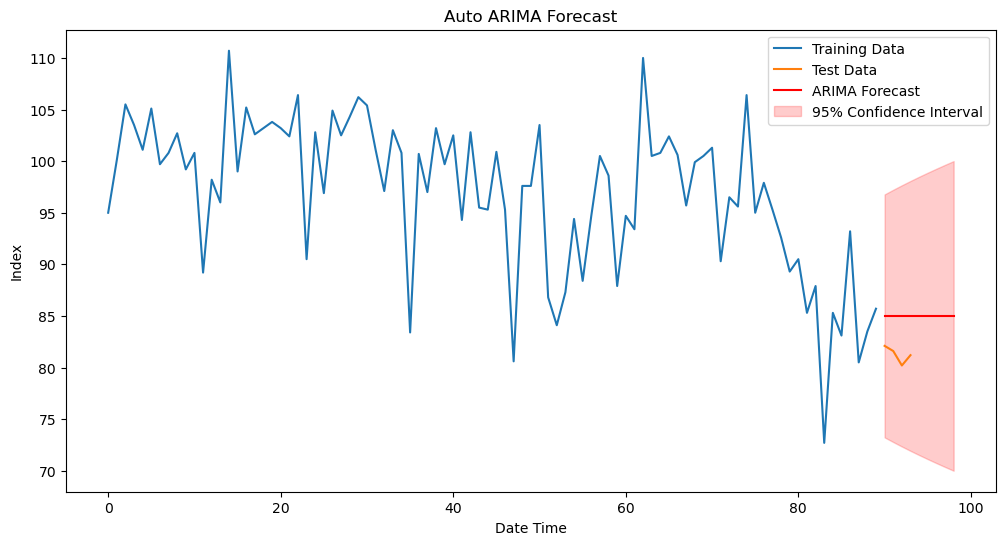

In [40]:
forecast, conf_int = arima_model.predict(
    n_periods=test_size, return_conf_int=True)

plt.figure(figsize=(12, 6))

plt.plot(train.index, train['index'], label='Training Data')
plt.plot(test.index, test['index'], label='Test Data')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')

plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1],
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.title('Auto ARIMA Forecast')
plt.xlabel('Date Time')
plt.ylabel('Index')
plt.legend()
plt.show()

In [168]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import numpy as np

#productionindexes['date'] = pd.to_datetime(productionindexes[['year', 'month']].assign(day=1))

productionindexes['Lag1'] = productionindexes['index'].shift(1)
productionindexes['Lag2'] = productionindexes['index'].shift(2)
productionindexes['Lag3'] = productionindexes['index'].shift(3)
productionindexes['Lag12'] = productionindexes['index'].shift(12)
productionindexes


,year,month,index,index_cleaned,Lag1,Lag2,Lag3,Lag12
0,2016,1,95.0,98.4,NaN,NaN,NaN,NaN
1,2016,2,100.1,98.2,95.0,NaN,NaN,NaN
2,2016,3,105.5,107.1,100.1,95.0,NaN,NaN
3,2016,4,103.5,100.7,105.5,100.1,95.0,NaN
4,2016,5,101.1,102.2,103.5,105.5,100.1,NaN
...,...,...,...,...,...,...,...,...
94,2023,11,NaN,NaN,81.2,80.2,81.6,87.9
95,2023,12,NaN,NaN,NaN,81.2,80.2,72.7
96,2024,1,NaN,NaN,NaN,NaN,81.2,85.3
97,2024,2,NaN,NaN,NaN,NaN,NaN,83.1


In [169]:
# train model with all values not containing nans
bool_series = productionindexes['index'].isna()
first_index = bool_series.idxmax()
productionindexes_model = productionindexes[12:first_index]

# get data to train
X_lags_ext = sm.add_constant(productionindexes_model.loc[:, 'Lag1':'Lag12'])
y_index_ext = productionindexes_model.loc[:, 'index']

# AR model (using OLS)
model = sm.OLS(y_index_ext, X_lags_ext).fit()

# Get the beta coefficients
betas = np.array(model.params)

# predict future prod indexes
X_array = np.array([1,productionindexes.at[first_index,'Lag1'],productionindexes.at[first_index,'Lag2'], 
                    productionindexes.at[first_index,'Lag3'], productionindexes.at[first_index,'Lag12']])

lag1, lag2 = np.nan, np.nan
for idx, row in productionindexes[first_index:].iterrows():
    # predict and safe
    index_pred = betas.dot(X_array)
    productionindexes.at[idx, 'index'] = index_pred

    # update data for next iteration
    lag1, lag2 = X_array[1], X_array[2]
    X_array[2], X_array[3]  = lag1, lag2 #shift backwards
    X_array[1] = index_pred

    if idx+2 < len(productionindexes): 
        X_array[4] = productionindexes.at[idx+1, 'Lag12']    

productionindexes

,year,month,index,index_cleaned,Lag1,Lag2,Lag3,Lag12
0,2016,1,95.000000,98.4,NaN,NaN,NaN,NaN
1,2016,2,100.100000,98.2,95.0,NaN,NaN,NaN
2,2016,3,105.500000,107.1,100.1,95.0,NaN,NaN
3,2016,4,103.500000,100.7,105.5,100.1,95.0,NaN
4,2016,5,101.100000,102.2,103.5,105.5,100.1,NaN
...,...,...,...,...,...,...,...,...
94,2023,11,79.457567,NaN,81.2,80.2,81.6,87.9
95,2023,12,70.486518,NaN,NaN,81.2,80.2,72.7
96,2024,1,74.473905,NaN,NaN,NaN,81.2,85.3
97,2024,2,71.371481,NaN,NaN,NaN,NaN,83.1


array([-25.72622789,   0.30147473,   0.33011138,   0.04733394,
         0.57299959])

In [25]:
def merge_prod_indexes(energydata):

    productionindexes = pd.read_csv(
        'C:/Users/Maria/Documents/Studium/Pyhton Projekte/PTSFC/energy_consumption/feature_selection/data/prod_index.csv')

    energydata['year'] = energydata.index.year
    energydata['month'] = energydata.index.month
    energydata = energydata.reset_index()

    merged = pd.merge(energydata, productionindexes, how='left', left_on=['year', 'month'], right_on=[
                      'year', 'month']).set_index('date_time').drop(columns={'year', 'half', 'month'})

    return merged

In [26]:
merged1 = merge_prod_indexes(energydata)
merged1.info()
merged1

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60541 entries, 2016-12-26 00:00:00 to 2023-11-22 12:00:00
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   energy_consumption  60541 non-null  float64
 1   index               60024 non-null  float64
 2   index_cleaned       60024 non-null  float64
dtypes: float64(3)
memory usage: 1.8 MB


,energy_consumption,index,index_cleaned
date_time,,,
2016-12-26 00:00:00,41.81025,89.2,86.7
2016-12-26 01:00:00,39.73950,89.2,86.7
2016-12-26 02:00:00,38.78525,89.2,86.7
2016-12-26 03:00:00,38.96900,89.2,86.7
2016-12-26 04:00:00,39.18750,89.2,86.7
...,...,...,...
2023-11-22 08:00:00,65.75125,NaN,NaN
2023-11-22 09:00:00,67.40950,NaN,NaN
2023-11-22 10:00:00,68.26775,NaN,NaN


In [ ]:
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split


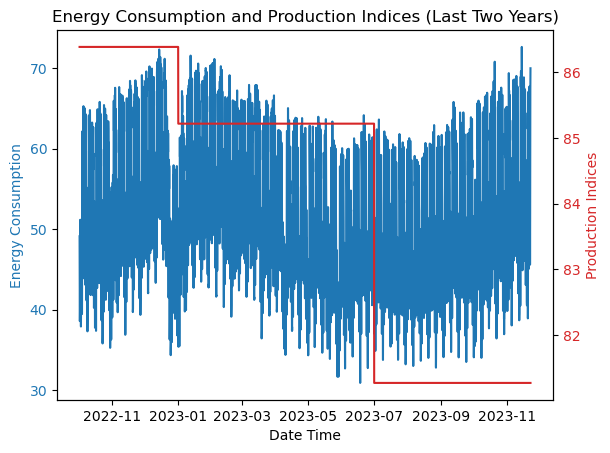

In [9]:
# ecplore, if one lag is better for energyconsumption

# Plotting
fig, ax1 = plt.subplots()

# Plot energy consumption on the left y-axis
ax1.set_xlabel('Date Time')
ax1.set_ylabel('Energy Consumption', color='tab:blue')
ax1.plot(merged.index,
         merged['energy_consumption'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot production indices on the right
ax2 = ax1.twinx()
ax2.set_ylabel('Production Indices', color='tab:red')
ax2.plot(merged.index,
         merged['index'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Display the plot
plt.title('Energy Consumption and Production Indices (Last Two Years)')
plt.show()

# Energiepreise 
* Höhere Preise können zu einer Verringerung des Verbrauchs führen, während niedrigere Preise ihn erhöhen können
* Besonders wichtig, da Energie bis dato nicht gespeichert werden kann
* Der Zustand der Energieinfrastruktur, einschließlich der Verfügbarkeit von Netzkapazitäten und Speichermöglichkeiten, kann den stündlichen Energieverbrauch beeinflussen (! Ukrainekrieg --> Politische Spannungen)
* Großhandelspreis Energie/ Abschätzung für Kosten durch Ausgleichsenergie --> Daten verfügbar (https://www.smard.de/blueprint/servlet/page/home/wiki-article/446/562)

Wichtig: Frage: Wann Timestamp --> Annahme: Werte für 1. des Monats gelten als Durchschnittswert für gesamten Monat

In [557]:
def get_energy_prices():
    energyprices = pd.read_csv(
        'C:/Users/Maria/Documents/Studium/Pyhton Projekte/PTSFC/energy_consumption/energy_prices.csv')

    energyprices['date'] = energyprices['date_time'].str.split(';').str[0]
    energyprices['date'] = pd.to_datetime(
        energyprices['date'], format='%d.%m.%Y').dt.date
    
    # prepare for merge
    energyprices['year'] = pd.to_datetime(energyprices['date']).dt.year
    energyprices['month'] = pd.to_datetime(energyprices['date']).dt.month

    energyprices = energyprices.drop(columns=['date_time']).rename(
        columns={'Unnamed: 1': 'price_mean_monthly'})

    return energyprices


def add_energy_prices(energydata, energyprices=None):
    if energyprices is None:
        energyprices = get_energy_prices()

    energydata = energydata.reset_index()
    energydata['date_time'] = pd.to_datetime(energydata['date_time'])

    # prepare for merge
    energydata['year'] = energydata['date_time'].dt.year
    energydata['month'] = energydata['date_time'].dt.month

    merged = pd.merge(energydata, energyprices,  how='left', left_on=['year', 'month'],
                      right_on=['year', 'month']).set_index('date_time').drop(columns=['year', 'month','date'])

    return merged

In [558]:
merged = add_energy_prices(merged)
merged


,tavg,wspd,sun_hours,close_weekly,abs_log_ret_weekly,energy_consumption,index,price_mean_monthly
date_time,,,,,,,,
2016-12-28 00:00:00,4.1,18.7,8.113109,11464.379883,0.083182,45.54875,98.733333,NaN
2016-12-28 01:00:00,4.1,18.7,8.113109,11464.379883,0.083182,43.06450,98.733333,NaN
2016-12-28 02:00:00,4.1,18.7,8.113109,11464.379883,0.083182,41.96000,98.733333,NaN
2016-12-28 03:00:00,4.1,18.7,8.113109,11464.379883,0.083182,41.95750,98.733333,NaN
2016-12-28 04:00:00,4.1,18.7,8.113109,11464.379883,0.083182,43.31375,98.733333,NaN
...,...,...,...,...,...,...,...,...
2023-11-22 08:00:00,-1.2,11.2,8.752074,15893.090234,0.311336,65.75125,81.275000,12.0
2023-11-22 09:00:00,-1.2,11.2,8.752074,15893.090234,0.311336,67.40950,81.275000,12.0
2023-11-22 10:00:00,-1.2,11.2,8.752074,15893.090234,0.311336,68.26775,81.275000,12.0


# Zeitpunkt 
* Wochentag, Tagesstunde, Jahreszeit
* Ferien und Brückentage, besonderes Ereignis (Silvester, Karfreitag,..)

# Korrelation
* Annahme: Temperatur und Seasonality hoch, Preise und Sonnenstunden/ Wind hoch